In [11]:
%matplotlib inline


# Feature importances with a forest of trees

This example shows the use of a forest of trees to evaluate the importance of
features on an artificial classification task. The blue bars are the feature
importances of the forest, along with their inter-trees variability represented
by the error bars.


In [13]:
import matplotlib.pyplot as plt

## Loading data




In [37]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Reading dataset
observations = pd.read_csv("combined_joro_unbalanced.csv")

# Last column (classes)
y = observations.iloc[: , -1]

# Droping lon/lat columns
X = observations.iloc[:, 0:19]
#X = observations.drop(observations.columns[[19]],axis=1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [39]:
X_train

,Annual_mean_temp,MeanDiurnalRange,Isothermality,TempSeasonality,MaxTempWarmMo,MinTempColdMo,TempAnnRange,MeanTempWetQtr,MeanTempDryQtr,MeanTempWarmQtr,MeanTempColdQtr,AnnPercip,PercipWetMo,PercipDryMo,PercipSeasonality,PrecipWetQtr,PrecipDryQtr,PrecipWrmQtr,PrecipColdQtr
2037,11.83517,9.659667,27.22260,974.04890,29.100,-6.384,35.484000,23.24067,-0.436667,23.46467,-0.436667,1221,270,30,79.00628,660,97,635,97
10733,24.94867,11.360000,57.29271,203.48880,35.744,15.916,19.828000,23.72467,25.328670,28.05467,23.072000,761,142,1,82.03139,350,5,152,43
447,11.86683,9.941000,27.70933,980.20140,29.220,-6.656,35.876000,23.29733,-0.504667,23.57333,-0.504667,1223,270,31,78.74475,659,98,636,98
311,10.48600,9.234667,26.11909,977.97610,27.532,-7.824,35.356000,21.88133,-1.892000,22.15267,-1.892000,1281,298,28,83.33064,703,93,696,93
21508,26.66500,8.630667,90.81089,32.55848,31.568,22.064,9.504000,26.58933,26.544670,26.99333,26.203330,2902,309,185,13.88953,841,604,710,672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,27.48550,8.758333,87.65347,25.31935,32.460,22.468,9.991999,27.29733,27.406670,27.75867,27.192670,2749,328,121,31.65337,889,403,694,879
24400,12.53650,11.387000,25.94795,1230.12300,36.368,-7.516,43.884000,12.81000,25.859330,27.85333,-2.528000,120,17,3,41.74986,48,13,16,27
2448,15.40383,9.709667,28.22577,941.74550,31.600,-2.800,34.400000,26.69933,3.388667,26.69933,3.388667,873,192,13,68.92648,415,62,415,62
8370,22.61317,11.667000,47.17370,284.95850,34.324,9.592,24.732000,23.79133,20.427330,25.44400,18.504670,1284,238,3,86.25174,655,16,392,25


A random forest classifier will be fitted to compute the feature importances.



In [40]:
from sklearn.ensemble import RandomForestClassifier

feature_names = X_train.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Feature importance based on mean decrease in impurity
Feature importances are provided by the fitted attribute
`feature_importances_` and they are computed as the mean and standard
deviation of accumulation of the impurity decrease within each tree.

<div class="alert alert-danger"><h4>Warning</h4><p>Impurity-based feature importances can be misleading for **high
    cardinality** features (many unique values). See
    `permutation_importance` as an alternative below.</p></div>



In [41]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.015 seconds


Let's plot the impurity-based importance.



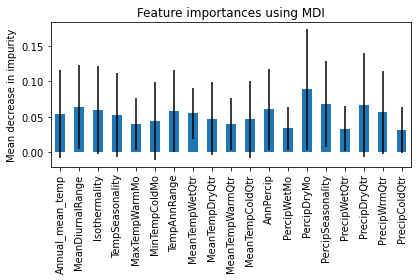

In [64]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [65]:
pd.DataFrame(forest_importances).sort_values(by=[0]).tail(10)

,0
Annual_mean_temp,0.054449
MeanTempWetQtr,0.055331
PrecipWrmQtr,0.056244
TempAnnRange,0.058207
Isothermality,0.059474
AnnPercip,0.060629
MeanDiurnalRange,0.063843
PrecipDryQtr,0.066390
PercipSeasonality,0.068375
PercipDryMo,0.088735


## Feature importance based on feature permutation
Permutation feature importance overcomes limitations of the impurity-based
feature importance: they do not have a bias toward high-cardinality features
and can be computed on a left-out test set.



In [66]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 10.798 seconds


In [67]:
pd.DataFrame(forest_importances).sort_values(by=[0]).tail(10)


,0
PrecipWrmQtr,0.001193
Isothermality,0.001305
MeanDiurnalRange,0.001653
MeanTempDryQtr,0.001926
AnnPercip,0.001988
Annual_mean_temp,0.002075
PrecipDryQtr,0.003206
PercipSeasonality,0.004262
MeanTempWetQtr,0.004983
PercipDryMo,0.006188


The computation for full permutation importance is more costly. Features are
shuffled n times and the model refitted to estimate the importance of it.
Please see `permutation_importance` for more details. We can now plot
the importance ranking.



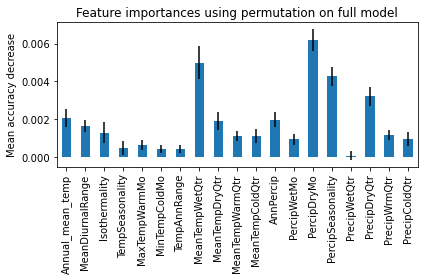

In [44]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### TODO
Check this reference for other methods of finding important features:
- https://machinelearningmastery.com/calculate-feature-importance-with-python/